# Deep backward schemes for high-dimensional nonlinear PDEs

---
# Contents
- [Important: Usage of `dbdp`](#important-usage-of-dbdp)
- [Example 1 : PDEs with bounded solution and simple structure](#example-1--pdes-with-bounded-solution-and-simple-structure)
---

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

Import necessary `dbdp` modules.

In [2]:
from dbdp import DBDPModel
from dbdp.solvers import DBDP1Solver, DBDP2Solver
from dbdp.utils import get_device

Get a GPU device if needed.

In [3]:
# device = get_device("gpu")  # Do not use GPU, the performance is terrible...
device = get_device("cpu")
device

device(type='cpu')

## Important: Usage of `dbdp`

To use `dbdp` for solving PDEs, you need to create a class that extend `DBDPModel` and define dynamic of the problem.
You must define : 
- `drift` for $\mu(t,x)$,
- `diffusion` for $\sigma(t,x)$,
- `f` for $f(t,x,y,z)$,
- `g` for $g(x)$,

and the property `dim` for the dimension $d$ of the problem.

Every `torch.Tensor` members should be assigned using the function `self.make_buffer`, this ensure that thoses tensors lives in the correct device (CPU or GPU) when the class is moved to a target device.

See `Example1Model` class bellow for an example.

## Example 1 : PDEs with bounded solution and simple structure

$$
    \mu=0.2,\quad \sigma=1,\quad T=2,\quad x_0=1
$$

$$
    g(x)=\cos(x)
$$

$$
    f(t,x,y,z)=(\cos(x)(e^{\frac{T-t}{2}}+\sigma^2/2)+\mu\sin(x))e^{\frac{T-t}{2}}-\frac{1}{2}(\sin(x)\cos(x)e^{T-t})^2+\frac{1}{2}(yz)^2
$$

In [4]:
class Example1Model(DBDPModel):
    def __init__(self, mu: float, sigma: float, maturity: float, dim: int):
        super().__init__()

        self._mu = self.make_buffer(mu * torch.ones(dim) / dim)
        self._sigma = self.make_buffer(sigma * torch.eye(dim) / np.sqrt(dim))
        self._maturity = maturity
        self._dim = dim

    def drift(self, t, x) -> torch.Tensor:
        return self._mu

    def diffusion(self, t, x) -> torch.Tensor:
        return self._sigma

    # NOTE: Here `self.maturity` is a scalar and should not be moved to GPU.
    # See https://discuss.pytorch.org/t/do-operations-between-tensors-and-scalars-move-the-tensor-to-cpu/189736
    def f(self, t: torch.Tensor, x: torch.Tensor, y: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        x = torch.sum(x, dim=1, keepdim=True)
        z = torch.sum(z, dim=1, keepdim=True)

        a = torch.cos(x) * (torch.exp((self._maturity - t) * 0.5) + 0.5) + 0.2 * torch.sin(x)
        b = 0.5 * (torch.sin(x) * torch.cos(x) * torch.exp(self._maturity - t)) ** 2
        c = 0.5 / self._dim * (y * z) ** 2
        return a * torch.exp((self._maturity - t) * 0.5) - b + c

    def g(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.sum(x, dim=1, keepdim=True)
        return torch.cos(x)

    @property
    def dim(self) -> int:
        return self._dim

    def true_u(self, t: float, x: torch.Tensor) -> torch.Tensor:
        x = torch.sum(x, dim=1, keepdim=True)
        return np.exp((self._maturity - t) / 2) * torch.cos(x)

In [5]:
mu = 0.2
sigma = 1.0

### Solving in dimension $d=1$

In [6]:
maturity = 2.0

example_1_1d = Example1Model(mu, sigma, maturity, dim=1)

x = torch.ones(example_1_1d.dim)

Generate datas, using `DBDPModel`.

In [7]:
time_steps = 240
dt = maturity / time_steps
sample_count = 10_000

x_paths, dw = example_1_1d.generate_datas(x, dt, time_steps, sample_count)

print(f"        | Shapes                      | Memory")
print(f"--------|-----------------------------|--------")
print(f"     dw | {dw.shape} | {dw.element_size() * dw.nelement() / 1024**2:.2f} MB")
print(f"x_paths | {x_paths.shape} | {x_paths.element_size() * x_paths.nelement() / 1024**2:.2f} MB")

        | Shapes                      | Memory
--------|-----------------------------|--------
     dw | torch.Size([10000, 240, 1]) | 9.16 MB
x_paths | torch.Size([10000, 241, 1]) | 9.19 MB


In [ ]:
example_1_1d_solver = DBDP1Solver(example_1_1d, dt, time_steps)
example_1_1d_solver.load("../models/example-01-1d-dbdp1.pt")

print(example_1_1d_solver._network[0].u_network)

Model loaded from ../models/example-01-1d-dbdp1-bis.pt
FeedForward(
  (_layers): Sequential(
    (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1, out_features=11, bias=True)
    (2): Tanh()
    (3): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=11, out_features=11, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=11, out_features=1, bias=True)
  )
)


In [ ]:
# trains_losses, tests_losses = example_1_1d_solver.train(
#     x_paths,
#     dw,
#     n_epochs_1=10_000,
#     n_epochs_2=200,
#     batch_size=1_000,
#     lr=1e-4,
#     device=device,
# )

# example_1_1d_solver.save("../models/example-01-1d-dbdp1.pt")

Training: 100%|█████████▉| 239/240 [00:13<00:00, 17.60it/s]


Model saved to ../models/example-01-1d-dbdp1-bis.pt


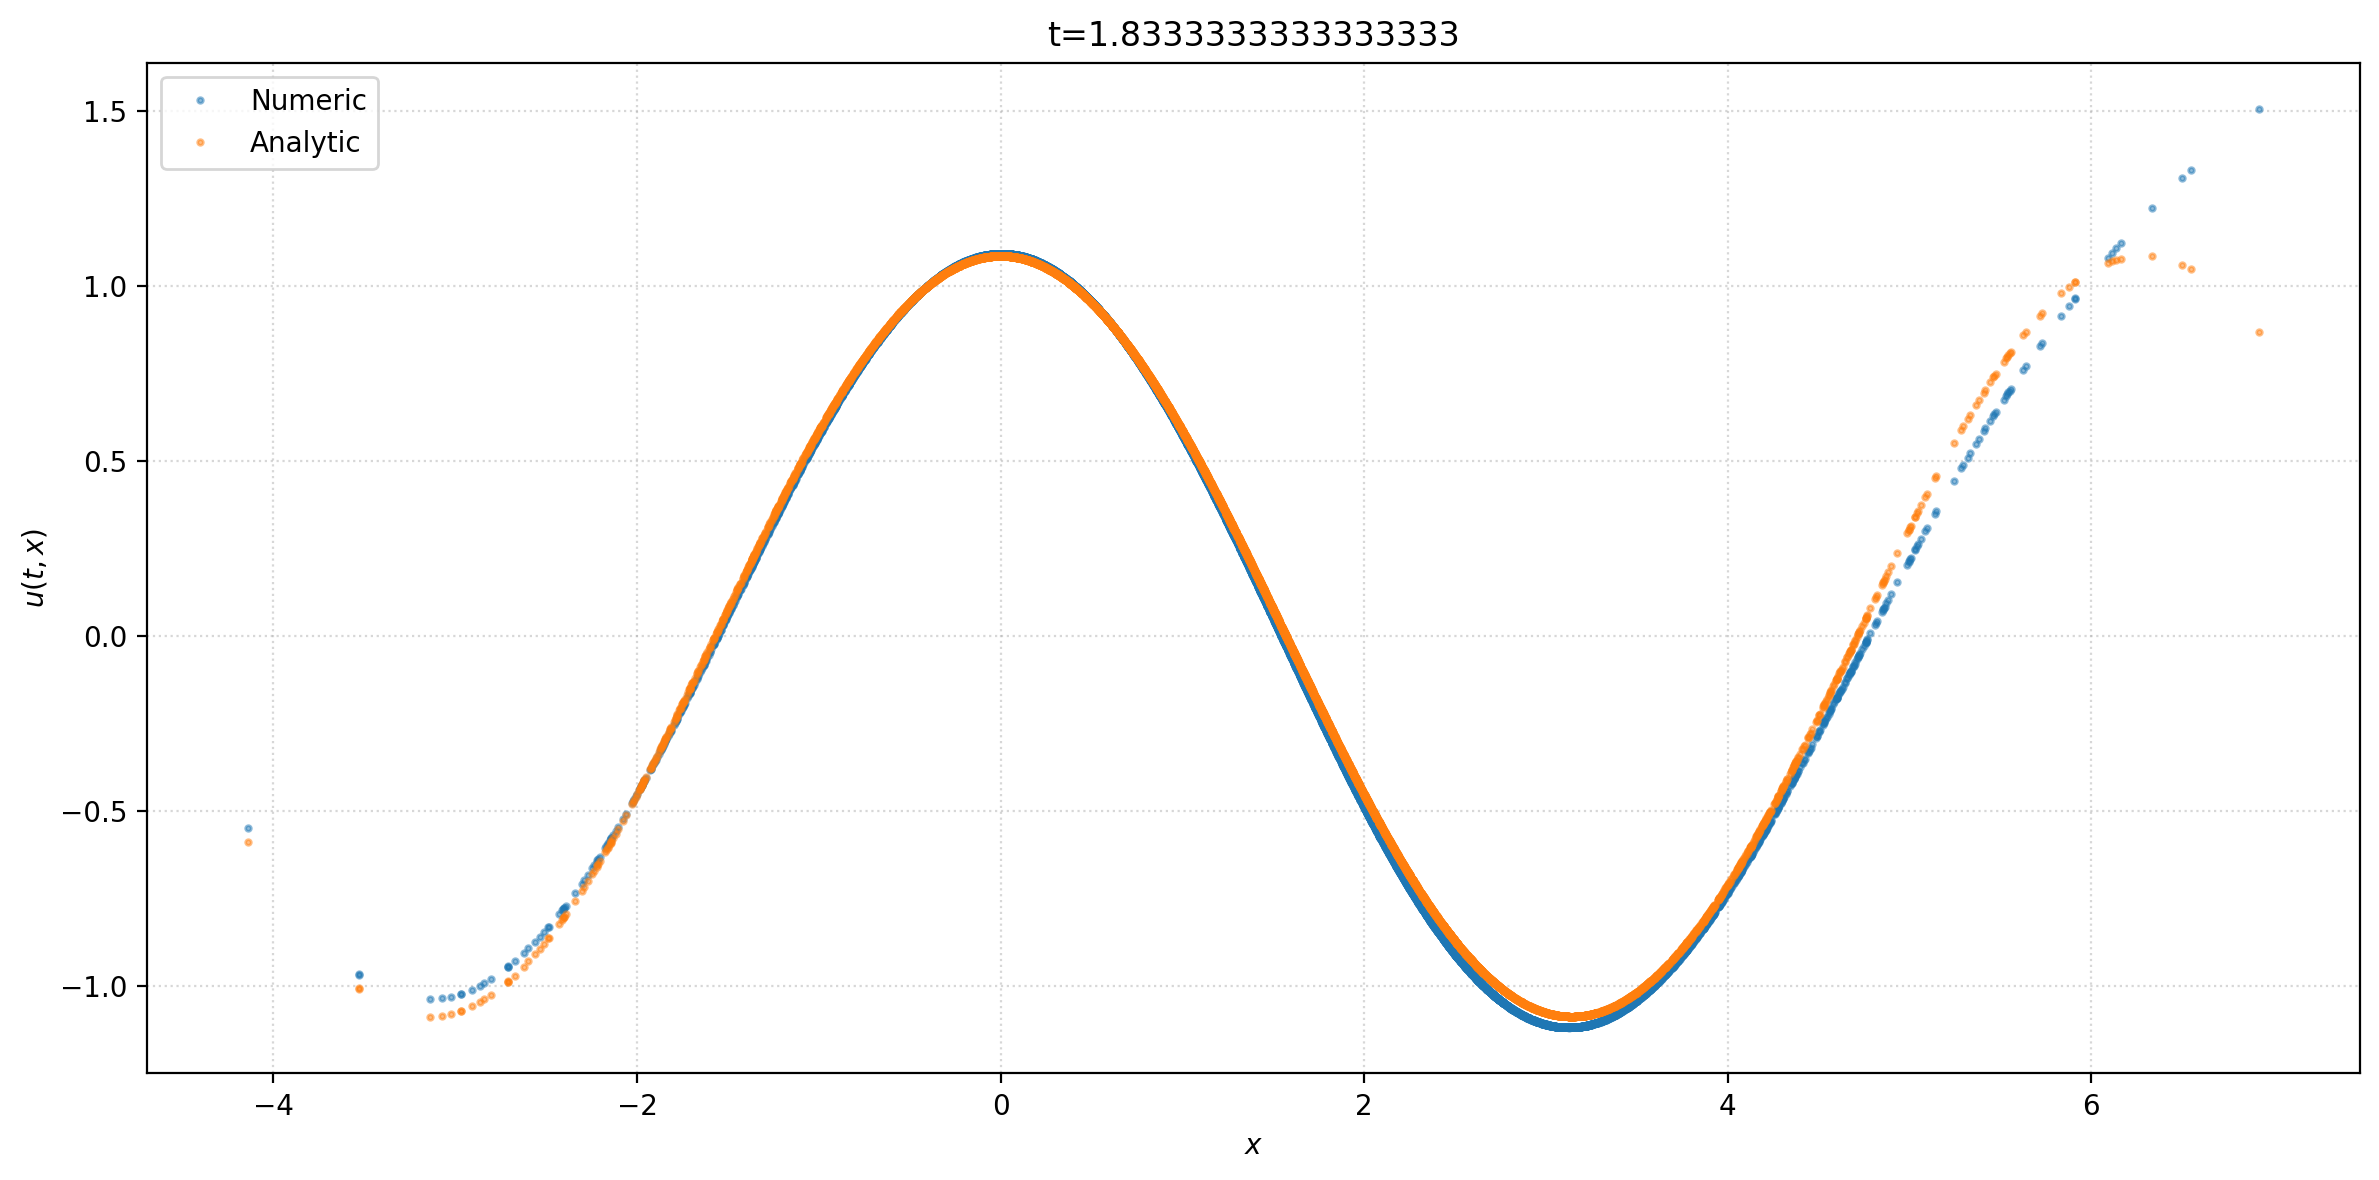

In [30]:
u_approx = example_1_1d_solver

time = np.linspace(0, maturity, time_steps + 1)
t = time[220]
xs = x_paths[:, 220].unsqueeze(1)[:, :, 0]
ys = u_approx(t, xs).detach()

plt.figure(figsize=(12, 6), dpi=200)
plt.title(f"t={t}")
plt.plot(xs, ys, ".", markersize=4, label="Numeric", alpha=0.5)
plt.plot(xs, example_1_1d.true_u(t, xs), ".", markersize=4, label="Analytic", alpha=0.5)
plt.grid(alpha=0.5, ls="dotted")
plt.xlabel("$x$")
plt.ylabel("$u(t,x)$")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

In [64]:
def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(12, 6), dpi=200)
    plt.title("Evolution of training and test error")
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.loglog()
    plt.grid(alpha=0.5, ls="dotted")
    plt.tight_layout()
    plt.legend()

In [ ]:
# plot_losses(trains_losses[-1], tests_losses[-1])

### Solving in dimension $d=5$

In [6]:
maturity = 1.0

example_1_5d = Example1Model(mu, sigma, maturity, dim=5)

x = torch.ones(example_1_5d.dim)

In [7]:
time_steps = 120
dt = maturity / time_steps
sample_count = 10_000

x_paths, dw = example_1_5d.generate_datas(x, dt, time_steps, sample_count)

print(f"        | Shapes                      | Memory  ")
print(f"--------|-----------------------------|---------")
print(f"     dw | {dw.shape} | {dw.element_size() * dw.nelement() / 1024**2:.2f} MB")
print(f"x_paths | {x_paths.shape} | {x_paths.element_size() * x_paths.nelement() / 1024**2:.2f} MB")

        | Shapes                      | Memory  
--------|-----------------------------|---------
     dw | torch.Size([10000, 120, 5]) | 22.89 MB
x_paths | torch.Size([10000, 121, 5]) | 23.08 MB


In [9]:
example_1_5d_solver = DBDP2Solver(example_1_5d, dt, time_steps)

print(example_1_5d_solver._network[0].u_network)

FeedForward(
  (_layers): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=15, bias=True)
    (2): Tanh()
    (3): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=15, out_features=1, bias=True)
  )
)


In [10]:
trains_losses, tests_losses = example_1_5d_solver.train(
    x_paths,
    dw,
    n_epochs_1=10_000,
    n_epochs_2=200,
    batch_size=1_000,
    lr=1e-4,
    device=device,
)

example_1_5d_solver.save("../models/example-01-5d-dbdp1.pt")

Training:  99%|█████████▉| 119/120 [30:40<00:15, 15.46s/it]  

Model saved to ../models/example-01-5d-dbdp1.pt


### Solving in dimension $d=50$

In [11]:
maturity = 1.0

example_1_50d = Example1Model(mu, sigma, maturity, dim=50)

x = torch.ones(example_1_50d.dim)

In [56]:
time_steps = 120
dt = maturity / time_steps
sample_count = 10_000

x_paths, dw = example_1_50d.generate_datas(x, dt, time_steps, sample_count)

print(f"        | Shapes                       | Memory   ")
print(f"--------|------------------------------|----------")
print(f"     dw | {dw.shape} | {dw.element_size() * dw.nelement() / 1024**2:.2f} MB")
print(f"x_paths | {x_paths.shape} | {x_paths.element_size() * x_paths.nelement() / 1024**2:.2f} MB")

        | Shapes                       | Memory   
--------|------------------------------|----------
     dw | torch.Size([10000, 120, 50]) | 228.88 MB
x_paths | torch.Size([10000, 121, 50]) | 230.79 MB


In [57]:
example_1_50d_solver = DBDP1Solver(example_1_50d, dt, time_steps)

print(example_1_50d_solver._network[0].u_network)

FeedForward(
  (_layers): Sequential(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=50, out_features=60, bias=True)
    (2): Tanh()
    (3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=60, out_features=1, bias=True)
  )
)


In [58]:
trains_losses, tests_losses = example_1_50d_solver.train(
    x_paths,
    dw,
    n_epochs_1=10_000,
    n_epochs_2=300,
    batch_size=1_000,
    lr=1e-4,
    device=device,
)

example_1_50d_solver.save("../models/example-01-50d-dbdp1.pt")

Training:  99%|█████████▉| 119/120 [52:10<00:26, 26.30s/it]  

Model saved to ../models/example-01-50d-dbdp1.pt


In [73]:
time = np.linspace(0, maturity, time_steps + 1)
i = -2
t = time[i]
xs = x.unsqueeze(0)
ys = example_1_50d_solver(t, xs).detach()
true_ys = example_1_50d.true_u(t, xs)

print(f"{ys=}, {true_ys=}")

ys=tensor([[1.0490]]), true_ys=tensor([[0.9690]])


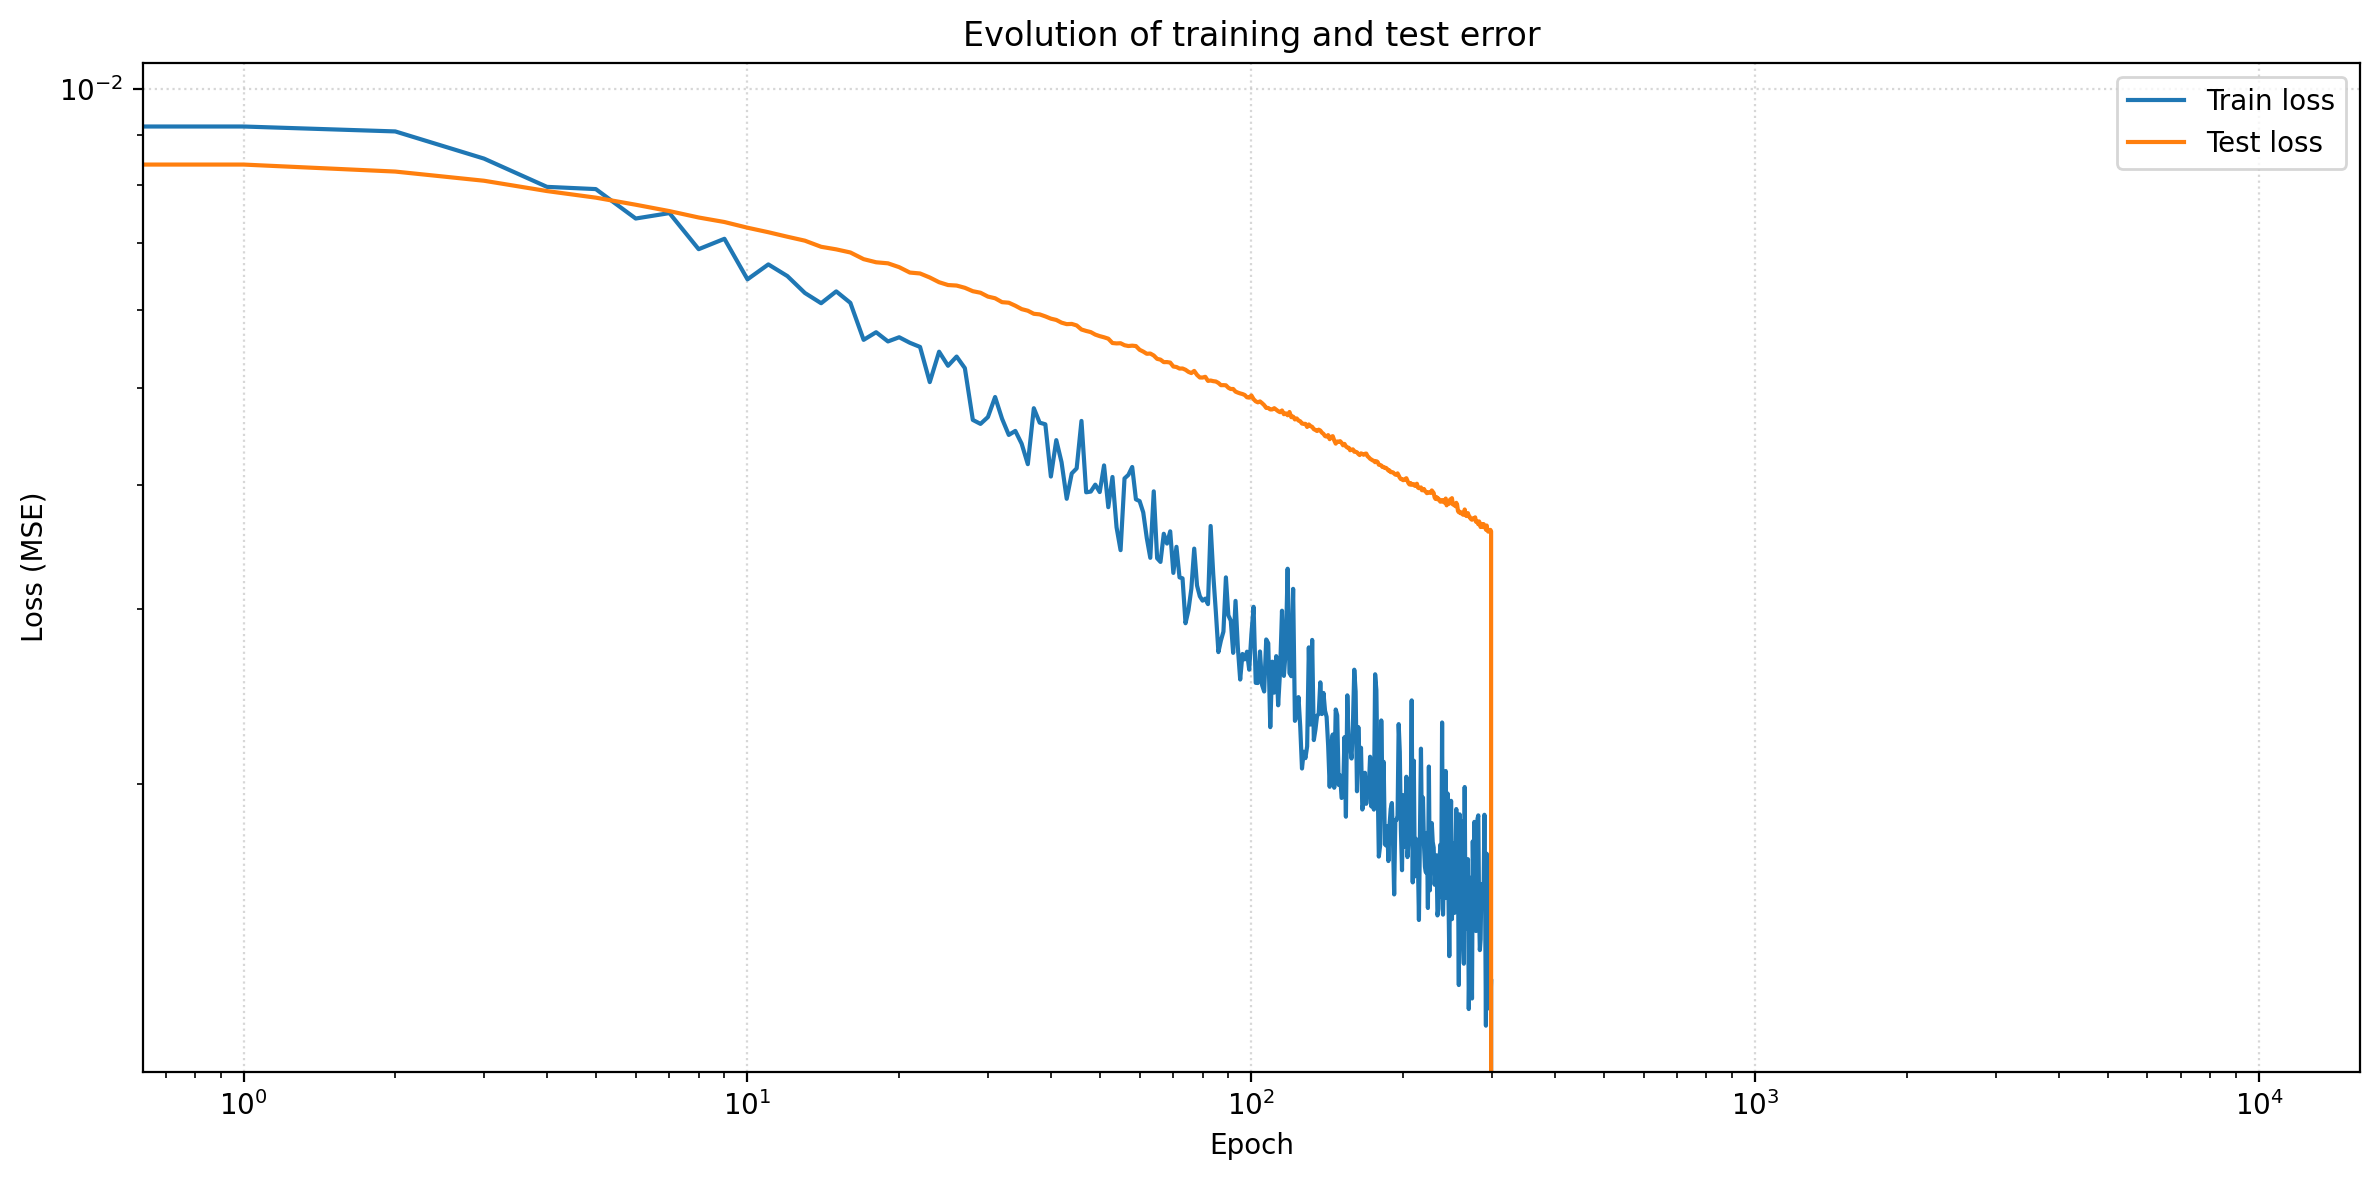

In [71]:
plot_losses(trains_losses[-2], tests_losses[-2])